# The Data: Amazon and Google

## Let's Visualise the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

data = pd.read_excel('Bloomberg Data.xlsx', engine='openpyxl', skiprows=9)
data['Dates'] = pd.to_datetime(data['Dates'])
data.set_index('Dates', inplace=True)

print(data.head(3))

            AMZN US Equity  GOOGL US Equity
Dates                                      
2004-08-18           39.36           85.000
2004-08-19           38.63          100.335
2004-08-20           39.51          108.310


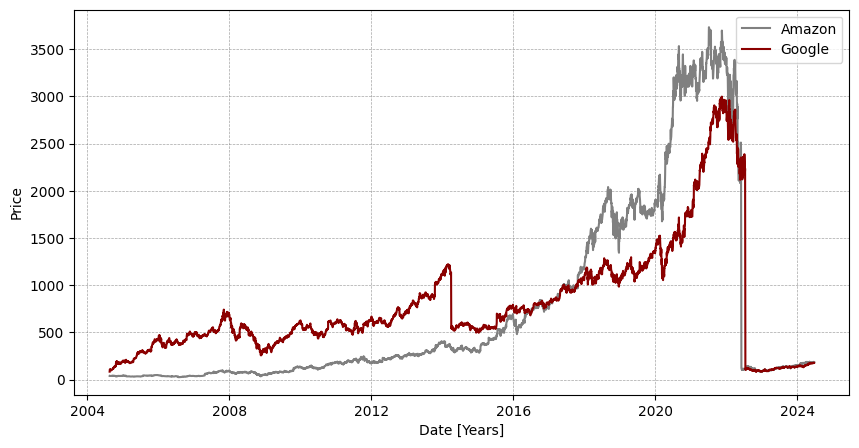

In [3]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(data['AMZN US Equity'], label='Amazon', color = "grey")
plt.plot(data['GOOGL US Equity'], label='Google', color = "darkred")

ax = plt.gca()
plt.xlabel('Date [Years]')
plt.ylabel('Price')
plt.legend()
plt.savefig('AmazonGoogle.png')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.show()

## Parameter estimation

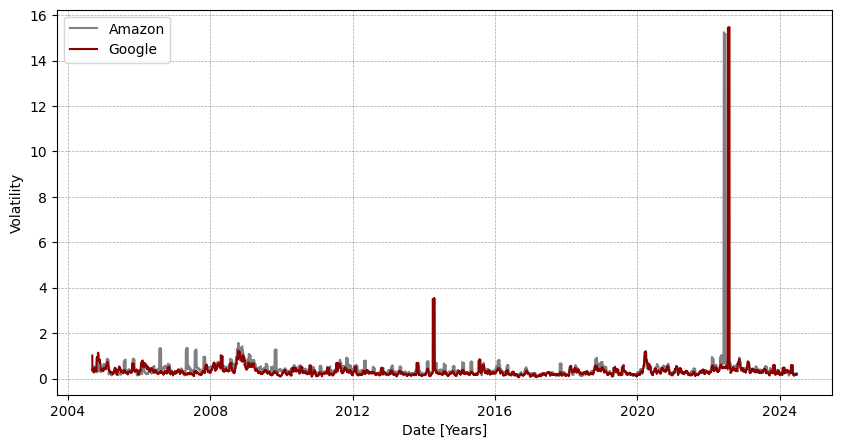

In [4]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

returns = np.log(data/data.shift(1)).dropna()                # daily log returns.
volatility = returns.rolling(window=14).std() * np.sqrt(365) # rolling volatility (14-day window) and we annualise it.

volatility.dropna(inplace=True)
S  = data.iloc[14:].values.T
V  = volatility.values.T
dt = 1/365

plt.style.use('default')
plt.figure(figsize=(10, 5))

plt.plot(volatility['AMZN US Equity'], label='Amazon', color = "grey")
plt.plot(volatility['GOOGL US Equity'], label='Google', color = "darkred")
plt.xlabel('Date [Years]')
ax = plt.gca()
plt.ylabel('Volatility')
plt.legend(['Amazon', 'Google'])
plt.savefig('Volatility.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.show()

In [5]:
ParamEstimation = pd.read_excel('ParamEstimation.xlsx')
np.round(ParamEstimation, decimals = 2)

,Log-likelihood Value,mu1,mu2,k1,k2,theta1,theta2,xi1,xi2,rho_ss,rho_sv1,rho_sv2
0,99374180.81,0.92,0.74,3.19,3.40,0.43,0.38,0.67,0.50,-0.31,0.03,0.03
1,98898161.21,0.04,0.14,4.93,3.08,0.44,0.44,0.57,0.73,0.24,-0.03,-0.00
2,99841010.94,0.19,0.27,4.60,2.04,0.18,0.49,0.77,0.41,0.85,-0.01,-0.01
3,98683498.41,0.83,0.84,4.92,1.16,0.79,0.38,0.67,0.86,-0.74,0.01,-0.00
4,98855564.46,0.80,0.87,0.84,4.49,0.94,0.52,0.86,0.64,0.18,0.01,-0.04


# Simulate Paths

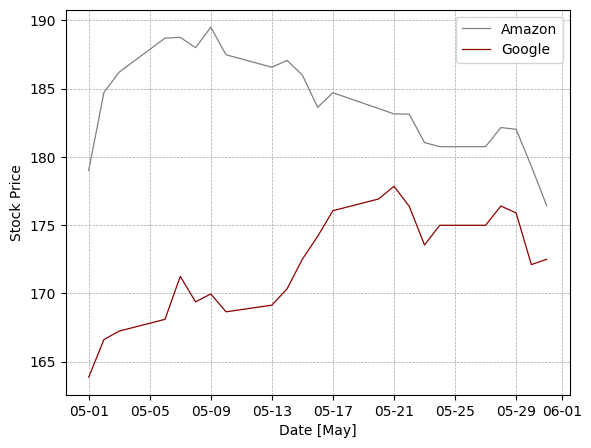

In [6]:
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter

end_date   = datetime(2024, 5, 31)          # Get May Stock Prices.
start_date = end_date - timedelta(days=30)
may_data   = data.loc[start_date:end_date]

plt.style.use('default')
plt.figure(figsize=(6.5, 5))
plt.plot(may_data.index, may_data['AMZN US Equity'], label='Amazon', color = "grey", linewidth = 0.9)
plt.plot(may_data.index, may_data['GOOGL US Equity'], label='Google', color = "darkred", linewidth = 0.9)
plt.xlabel('Date [May]')
plt.ylabel('Stock Price')
date_form = DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
ax = plt.gca()
plt.legend()
plt.savefig('MayPrices.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.show()

In [7]:
max_index      = ParamEstimation["Log-likelihood Value"].idxmax()
optimal_params = ParamEstimation.loc[max_index]

S1_31 = may_data.iloc[-1, 0] # Amazon 2024-05-31.
S2_31 = may_data.iloc[-1, 1] # Google 2024-05-31.
V1_31 = volatility.iloc[-1, 0]
V2_31 = volatility.iloc[-1, 1]
n  = 30                   # June has 30 days.
dt = 1/365                # Time step size.

mu    = np.array([optimal_params[1:3]])
kappa = np.array([optimal_params[4:6]])
theta = np.array([optimal_params[6:8]])
xi    = np.array([optimal_params[8:10]])

rho_ss  = optimal_params[9]
rho_sv1 = optimal_params[10]
rho_sv2 = optimal_params[11]

corr_matrix = np.array([[1       , rho_ss  , rho_sv1,  0     ],
                        [rho_ss  , 1       , 0      , rho_sv2],
                        [rho_sv1 , 0       , 1      , 0      ],
                        [0       , rho_sv2 , 0      , 1      ]])

C:\Users\masan\AppData\Local\Temp\ipykernel_15524\144313138.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_ss  = optimal_params[9]
C:\Users\masan\AppData\Local\Temp\ipykernel_15524\144313138.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_sv1 = optimal_params[10]
C:\Users\masan\AppData\Local\Temp\ipykernel_15524\144313138.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_sv2 = optimal_params[11]


In [23]:
def simulate_paths(n, S1, S2, V1, V2, corr_matrix, mu, kappa, theta, xi, dt):
    """
    Simulate paths for two stock prices and their volatilities using Euler discretization.

    Parameters:
    - n: Number of time steps (T - Time to maturity).
    - S1 & S2: Initial prices.
    - V1 & V2: Initial volatilities.
    - corr_matrix: Correlation matrix.
    - mu: Risk-free interest rate.
    - kappa: Mean-reversion rates for the volatilities.
    - theta: Long-term mean volatilities.
    - xi: Volatility of volatilities.
    - dt: Time step size.

    Returns:
    - S1_sim: Simulated paths for the first stock.
    - S2_sim: Simulated paths for the second stock.
    - tau: Time to maturity.
    """
    S1_sim = np.zeros((n+1,))
    S2_sim = np.zeros((n+1,))
    tau = np.zeros((n+1,))

    SSim = np.zeros((n+1, 2))
    VSim = np.zeros((n+1, 2))

    SSim[0, 0] = S1
    SSim[0, 1] = S2
    VSim[0, :] = [V1, V2]
    T = n
    tau[0] = T


    Z = np.random.randn(n, 4)

    C = np.linalg.cholesky(corr_matrix)
    Z_correlated = np.matmul(C, Z.T).T

    for i in range(n):
        dS = mu * SSim[i, :] * dt + np.sqrt(VSim[i, :]) * SSim[i, :] * np.sqrt(dt) * Z_correlated[i, 1:3]
        dV = kappa * (theta - VSim[i, :]) * dt + xi * np.sqrt(VSim[i, :]) * np.sqrt(dt) * Z_correlated[i, 3:]

        SSim[i+1, :] = SSim[i, :] + dS
        VSim[i+1, :] = VSim[i, :] + dV
        VSim[i+1, :] = np.maximum(VSim[i+1, :], 1e-6) # Bad!!! -
        tau[i+1] = T - (i+1)

    S1_sim = SSim[:, 0]
    S2_sim = SSim[:, 1]

    return S1_sim, S2_sim, tau/265 # annualise time to maturity

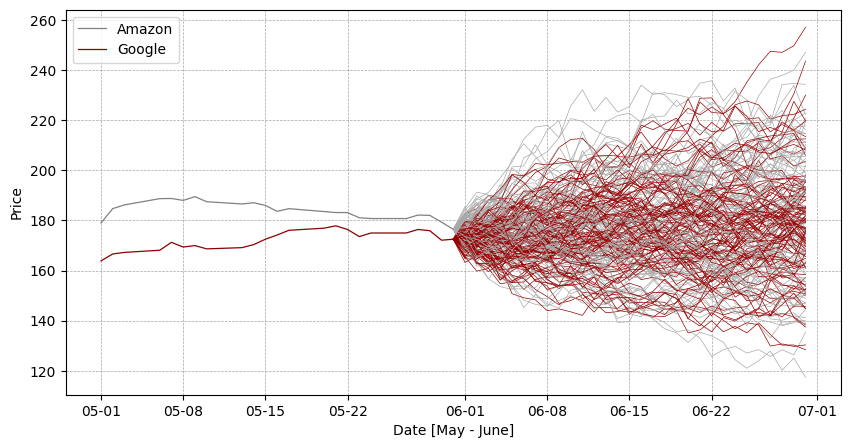

In [10]:
start_date = datetime(2024, 5, 31)
simulated_dates = [start_date + timedelta(days=i) for i in range(31)] # June.

plt.figure(figsize=(10, 5))
plt.style.use('default')
plt.plot(may_data['AMZN US Equity'], label = 'Amazon', color = "grey", linewidth = 0.9)
plt.plot(may_data['GOOGL US Equity'], label = 'Google', color = "darkred", linewidth = 0.9)

# Simulate a hundred paths
numpaths = 100
paths = [simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt) for i in range(numpaths)]

for path in paths:
    plt.plot(simulated_dates, path[0], linewidth = 0.5, color = "#A9A9A9")
    plt.plot(simulated_dates, path[1], linewidth = 0.5, color = "#990000")

plt.xlabel('Date [May - June]')
plt.ylabel('Price')
date_form = DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.legend(['Amazon', 'Google'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.savefig('JuneSimulatedPrices.png')

# Black-Scholes Hedge

In [11]:
from scipy.stats import norm

def payoff(path):   # To get the payoff HT
  difference = path[0] - path[1]
  return np.maximum(difference, 0)

def Phi(x):
    return norm.cdf(x)

def d1(St, Tt, sigmas, rho):
    S = St[0] / St[1]
    cov = np.prod(sigmas) * rho
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d1 = (np.log(S) + 0.5 * Tt * sig ** 2) / (sig * np.sqrt(Tt))
    return _d1

def d2(St, Tt, sigmas, rho):
    cov = np.prod(sigmas) * rho
    _d1 = d1(St, Tt, sigmas, rho)
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d2 = _d1 - sig * np.sqrt(Tt)
    return _d2

def price(path, Tt, sigmas, rho):
  price = path[0] * Phi(d1(path, Tt, sigmas, rho)) - path[1] * Phi(d2(path, Tt, sigmas, rho))
  return price

In [12]:
sigma = xi
rho   = rho_ss

In [13]:
tau = paths[0][2]

PNL_BS = []
Ht  = []

numpaths = 10000
paths = [simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt) for i in range(numpaths)]

for path_index, path in enumerate(paths):
    H = payoff(path)[-1]
    pathMat = np.column_stack((path[0], path[1]))
    V = price(pathMat[0], tau[0], sigma, rho)
    delta_S = np.diff(pathMat, axis=0)

    for i in range(len(delta_S)):
        Tt = tau[i]
        St = pathMat[i]
        phi1 = Phi(d1(St, Tt, sigma, rho))
        phi2 = -Phi(d2(St, Tt, sigma, rho))
        V += phi1 * delta_S[i, 0] + phi2 * delta_S[i, 1]

    pnl = V - H
    PNL_BS.append(pnl)

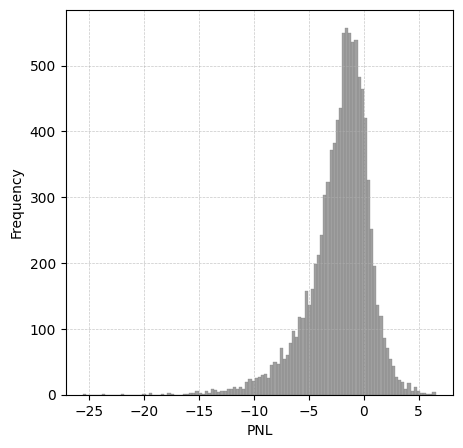

In [14]:
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.histplot(PNL_BS, color = "grey", edgecolor = "grey")
plt.xlabel('PNL')
plt.ylabel('Frequency')
plt.savefig('ProfitLossBS.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

# Neural Network Hedge

## Data Preparation - Train and Validation Data

In [15]:
# Separate into Training and Test Data!!!
from tqdm import tqdm
import torch
import copy

def prepare_data(numpaths, simulate_fn, sigma, rho):
  Stocks = []
  Prices = []
  for _ in tqdm(range(numpaths), desc = f'Simulating Paths {numpaths}'):
    path = simulate_fn()
    H = payoff(path)[-1]
    tau = path[2]
    pathmatrix = np.column_stack((path[0], path[1]))
    Ht = [price(pathmatrix[i], tau[i], sigma, rho) for i in range(len(path[0]) - 1)]
    Ht.append(H)

    S1 = torch.tensor(path[0], dtype=torch.float32).reshape(-1, 1)
    S2 = torch.tensor(path[1], dtype=torch.float32).reshape(-1, 1)
    Tau = torch.tensor(tau, dtype=torch.float32).reshape(-1, 1)
    Ht = torch.tensor(Ht, dtype=torch.float32).reshape(-1, 1)
    inputs = torch.cat((S1, S2, Tau), dim=1)

    Stocks.append(inputs)
    Prices.append(Ht)

  return Stocks, Prices   

In [25]:
numpaths = 1000
train_data, train_labels = prepare_data(numpaths,
                                        lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                        sigma, rho)
valid_data, valid_labels = prepare_data(numpaths,
                                       lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                       sigma, rho) 
numpaths_test = 10000 # Finally to compare to Black-Scholes
test_data, test_labels = prepare_data(numpaths_test,
                                      lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                      sigma, rho)

Simulating Paths 10000: 100%|██████████| 10000/10000 [05:32<00:00, 30.03it/s] 


## Hyperparameter Tuning

In [17]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class HedgingNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(HedgingNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc6 = nn.Linear(hidden_size[4], hidden_size[5])
        self.fc7 = nn.Linear(hidden_size[5], output_size)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = getattr(torch.nn.functional, self.activation_fn[0])(self.fc1(x))
        x = getattr(torch.nn.functional, self.activation_fn[1])(self.fc2(x))
        x = getattr(torch.nn.functional, self.activation_fn[2])(self.fc3(x))
        x = getattr(torch.nn.functional, self.activation_fn[3])(self.fc4(x))
        x = getattr(torch.nn.functional, self.activation_fn[4])(self.fc5(x))
        x = getattr(torch.nn.functional, self.activation_fn[5])(self.fc6(x))
        x = torch.tanh(self.fc7(x))  # Final layer activation remains tanh
        return x

def regularization_loss(model, reg_type, lambda_reg): # regularisation
    reg_loss = 0.0
    if reg_type == 'l1':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(torch.abs(param))
    elif reg_type == 'l2':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(param ** 2)
    return lambda_reg * reg_loss

def custom_loss(one_day_pl, delta_Ht, model, reg_type, lambda_reg):
    oneDayPL = torch.stack(one_day_pl).unsqueeze(1)
    mse_loss = F.mse_loss(oneDayPL, delta_Ht)
    reg_loss = regularization_loss(model, reg_type, lambda_reg)
    total_loss = mse_loss + reg_loss
    
    return total_loss

input_size = 3
hidden_size = [200, 200, 200, 200, 200, 200]  
output_size = 2
learning_rate = 0.001
epochs = 10000

activation_fn = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']  # Using ReLU for all hidden layers


In [ ]:
import optuna

def objective(trial):
    hidden_size = [trial.suggest_int(f'hidden_size_{i}', 100, 500) for i in range(1, 7)]
    activation_fn = [trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh']) for i in range(1, 7)]
    
    lambda_reg = trial.suggest_float('lambda_reg', 0.0, 1.0)
    reg_type   = trial.suggest_categorical('reg_type', ['l1', 'l2'])

    model = HedgingNet(input_size=3, hidden_size=hidden_size, output_size=2, activation_fn=activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    best_loss = float('inf')
    train_losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        epoch_losses = []

        for i in range(len(train_data)):
            inputs = train_data[i]
            Ht = train_labels[i]

            optimizer.zero_grad()
            outputs = model(inputs)
            phi1, phi2 = outputs[:, 0], outputs[:, 1]

            pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
            tau = inputs[:, 2].detach().numpy()
            V = price(pathmatrix[0], tau[0], sigma, rho)  
            one_day_PL = []

            for t in range(1, len(inputs)):
                delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
                delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
                V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
                one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

            delta_Ht = Ht[1:] - Ht[:-1]
            loss = custom_loss(one_day_PL, delta_Ht, model, reg_type, lambda_reg)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        average_loss = np.mean(epoch_losses)
        train_losses.append(average_loss)

        if average_loss < best_loss:
            best_loss = average_loss
            best_model = copy.deepcopy(model)

        scheduler.step(average_loss)

    return best_loss

study = optuna.create_study(study_name='Hyperparameter Tuning', direction='minimize')

no_trials = 10

with tqdm(total=no_trials, desc='Optuna Trials') as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=no_trials, callbacks=[callback])


In [276]:
best_trial = study.best_trial
best_hidden_size = [best_trial.params['hidden_size_1'], 
                    best_trial.params['hidden_size_2'], 
                    best_trial.params['hidden_size_3'], 
                    best_trial.params['hidden_size_4'],
                    best_trial.params['hidden_size_5'],
                    best_trial.params['hidden_size_6']]

best_lambda_reg = best_trial.params['lambda_reg']
best_reg_type   = best_trial.params['reg_type']

best_activation_fn = [best_trial.params[f'activation_{i}'] for i in range(1, 7)]


Activation functions (6):  ['sigmoid', 'sigmoid', 'relu', 'sigmoid', 'tanh', 'tanh']
Hidden Size:               [199, 298, 285, 373, 429, 124]
Regularisation Type:       l2
Regularisation Value:      0.03870965343251043


HedgingNet(
  (fc1): Linear(in_features=3, out_features=199, bias=True)
  (fc2): Linear(in_features=199, out_features=298, bias=True)
  (fc3): Linear(in_features=298, out_features=285, bias=True)
  (fc4): Linear(in_features=285, out_features=373, bias=True)
  (fc5): Linear(in_features=373, out_features=429, bias=True)
  (fc6): Linear(in_features=429, out_features=124, bias=True)
  (fc7): Linear(in_features=124, out_features=2, bias=True)
)

In [19]:
best_hidden_size   = [199, 298, 285, 373, 429, 124]
best_activation_fn = ['sigmoid', 'sigmoid', 'relu', 'sigmoid', 'tanh', 'tanh']
best_reg_type      = 'l2'
best_lambda_reg    = 0.03870965343251043

model = HedgingNet(input_size=3, hidden_size=best_hidden_size, output_size=2, activation_fn=best_activation_fn)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print('Activation functions (6): ', best_activation_fn)  # except the output layer
print('Hidden Size:              ', best_hidden_size)
print('Regularisation Type:      ', best_reg_type)
print('Regularisation Value:     ', best_lambda_reg)

model.eval()

Activation functions (6):  ['sigmoid', 'sigmoid', 'relu', 'sigmoid', 'tanh', 'tanh']
Hidden Size:               [199, 298, 285, 373, 429, 124]
Regularisation Type:       l2
Regularisation Value:      0.03870965343251043


HedgingNet(
  (fc1): Linear(in_features=3, out_features=199, bias=True)
  (fc2): Linear(in_features=199, out_features=298, bias=True)
  (fc3): Linear(in_features=298, out_features=285, bias=True)
  (fc4): Linear(in_features=285, out_features=373, bias=True)
  (fc5): Linear(in_features=373, out_features=429, bias=True)
  (fc6): Linear(in_features=429, out_features=124, bias=True)
  (fc7): Linear(in_features=124, out_features=2, bias=True)
)

## Train the Best Network from the Tuning

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=10)

best_loss = float('inf')
best_model = None
best_pnl_std = float('inf')

train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs), desc="Learning!!!"):
    model.train()
    epoch_PNL_train = []
    epoch_losses    = []

    # Training phase
    for i in range(len(train_data)):
        inputs = train_data[i]
        Ht = train_labels[i]

        optimizer.zero_grad()
        outputs = model(inputs)
        phi1, phi2 = outputs[:, 0], outputs[:, 1]

        pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
        tau = inputs[:, 2].detach().numpy()
        V = price(pathmatrix[0], tau[0], sigma, rho)
        one_day_PL = []

        for t in range(1, len(inputs)):
            delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
            delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
            V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
            one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

        pnl = V - Ht[-1]
        epoch_PNL_train.append(pnl.item())

        delta_Ht = Ht[1:] - Ht[:-1]
        loss = custom_loss(one_day_PL, delta_Ht, model, best_reg_type, best_lambda_reg)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_train_loss = np.mean(epoch_losses)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    valid_losses_epoch = []
    epoch_PNL_valid = []
    with torch.no_grad():
        for i in range(len(valid_data)):
            inputs = valid_data[i]
            Ht = valid_labels[i]

            outputs = model(inputs)
            phi1, phi2 = outputs[:, 0], outputs[:, 1]

            pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
            tau = inputs[:, 2].detach().numpy()
            V = price(pathmatrix[0], tau[0], sigma, rho)
            one_day_PL = []

            for t in range(1, len(inputs)):
                delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
                delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
                V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
                one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

            pnl = V - Ht[-1]
            epoch_PNL_valid.append(pnl.item())

            delta_Ht = Ht[1:] - Ht[:-1]
            valid_loss = custom_loss(one_day_PL, delta_Ht, model, best_reg_type, best_lambda_reg)
            valid_losses_epoch.append(valid_loss.item())

    average_valid_loss = np.mean(valid_losses_epoch)
    valid_losses.append(average_valid_loss)

    scheduler.step(average_train_loss)
    current_lr = scheduler.get_last_lr()[0]

    print('\n')
    print(f'Learning Rate: {current_lr}')

    pnl_mean = np.mean(epoch_PNL_valid)
    pnl_std = np.std(epoch_PNL_valid)
    print(f"Train Loss: {average_train_loss:.6f} | Valid Loss: {average_valid_loss:.6f} | PNL Mean: {pnl_mean:.3f}, PNL Std: {pnl_std:.3f}")

    if pnl_std < best_pnl_std:
        best_pnl_std = pnl_std
        best_model = copy.deepcopy(model)


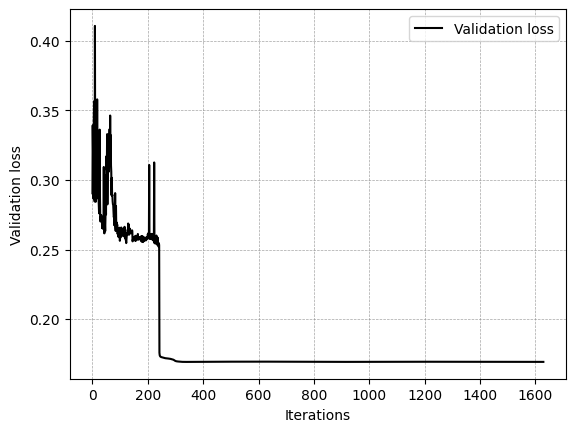

In [286]:
# plt.figure(figsize=(5,5))
sns.lineplot(valid_losses, color = 'black', label = 'Validation loss')
plt.ylabel('Validation loss')
plt.xlabel('Iterations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.savefig('Validation loss')
plt.show()


### Approximation of Out-Of-Sample Performance

In [281]:
# torch.save(best_model.state_dict(), 'best_model.pth')

In [20]:
hedgeNN = HedgingNet(input_size=3, hidden_size=best_hidden_size, output_size=2, activation_fn=best_activation_fn)
hedgeNN.load_state_dict(torch.load('best_model.pth'))
hedgeNN.eval()

C:\Users\masan\AppData\Local\Temp\ipykernel_15524\2078127831.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hedgeNN.load_state_dict(torch.load('best_model.pth'))


HedgingNet(
  (fc1): Linear(in_features=3, out_features=199, bias=True)
  (fc2): Linear(in_features=199, out_features=298, bias=True)
  (fc3): Linear(in_features=298, out_features=285, bias=True)
  (fc4): Linear(in_features=285, out_features=373, bias=True)
  (fc5): Linear(in_features=373, out_features=429, bias=True)
  (fc6): Linear(in_features=429, out_features=124, bias=True)
  (fc7): Linear(in_features=124, out_features=2, bias=True)
)

### Test data to compare with Black-Scholes 

In [26]:
# Fit on unseen data
PNL_NN = []
losses = []
for i in range(numpaths_test): # Using on Unseen Data and compare with BS Hedge!!!
    inputs = test_data[i]
    Ht     = test_labels[i]
    delta_Ht = Ht[1:] - Ht[:-1]
    with torch.no_grad():
        outputs = hedgeNN(inputs)
        phi1, phi2 = outputs[:, 0], outputs[:, 1]

        pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
        tau = inputs[:, 2].detach().numpy()
        V = price(pathmatrix[0], tau[0], sigma, rho)
        one_day_PL = []
        for i in range(1, len(inputs)):
          delta_S1 = (inputs[i,0] - inputs[i-1,0]).squeeze()
          delta_S2 = (inputs[i,1] - inputs[i-1,1]).squeeze()
          V += phi1[i-1].item() * delta_S1 + phi2[i-1].item() * delta_S2
          one_day_PL.append(phi1[i-1].item() * delta_S1 + phi2[i-1].item() * delta_S2)

        loss = custom_loss(one_day_PL, delta_Ht, hedgeNN, best_reg_type, best_lambda_reg)
        losses.append(loss.item())

    average_loss = np.mean(losses)
    pnl = V - Ht[-1]
    PNL_NN.append(pnl.item())

print('PNL Mean:', np.mean(PNL_NN))
print('PNL Std: ', np.std(PNL_NN))
print('Loss:    ', average_loss)


PNL Mean: -0.31895117377806453
PNL Std:  2.6440297881821135
Loss:     1488.1866309448242


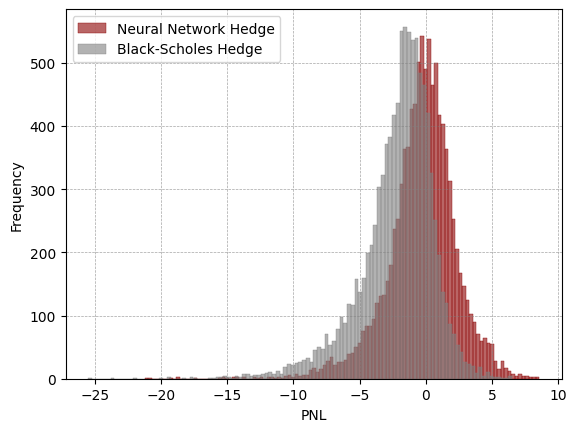

In [27]:
sns.histplot(PNL_NN, color="darkred", edgecolor="darkred", alpha=0.6, label="Neural Network Hedge")
sns.histplot(PNL_BS, color = "grey", edgecolor = "grey", alpha = 0.6, label = "Black-Scholes Hedge")
plt.xlabel('PNL')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.legend()
plt.savefig("sheesh.png")
plt.show()

In [28]:
print(f'PNL NN Mean: {np.mean(PNL_NN):.3f}, PNL NN Std: {np.std(PNL_NN):.3f}')
print(f'PNL BS Mean: {np.mean(PNL_BS):.3f}, PNL BS Std: {np.std(PNL_BS):.3f}')

PNL NN Mean: -0.319, PNL NN Std: 2.644
PNL BS Mean: -2.185, PNL BS Std: 2.812
